In [1]:
import numpy as np
import pandas as pd
import spacy,re
import nltk

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data

import pickle,json
with open('C:\\Users\\RW565TZ\\Week6\\complaints.json','rb') as f:
    data = json.load(f)
    df = pd.json_normalize(data)

In [3]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.shape

(78313, 22)

In [7]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [8]:
#Assigning new column names
df.columns = ["index","type","id","score","tags","zip_code","complaint_id","issue","date_received","state","consumer_disputed","product","company_response","company","submitted_via","date_sent_to_company","company_public_response","sub_product","timely","complaint_what_happened","sub_issue","consumer_consent_provided"]

In [9]:
df['company'].unique()

array(['JPMORGAN CHASE & CO.'], dtype=object)

In [10]:
df['submitted_via'].unique()

array(['Web', 'Referral', 'Phone', 'Postal mail', 'Fax', 'Email'],
      dtype=object)

In [11]:
df = df.drop('company',axis=1)
df = df.drop('submitted_via',axis=1)

In [12]:
# Assign nan in place of blanks in the complaints column
df['complaint_what_happened'].replace(r'', np.nan,inplace=True)

In [13]:
#Removing all rows where complaints column is nan

df = df[~df['complaint_what_happened'].isnull()]

In [14]:
# Function to clean the text and remove all the unnecessary elements.

def cleaned_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[\[].*?[\]]", "", sentence)
    sentence = re.sub(r'[^\w\s]','', sentence) 
    sentence = re.sub(r'[0-9]', '', sentence)
    
    return sentence

In [15]:
# Cleaning text

df_clean = pd.DataFrame()
df_clean['complaints']= pd.DataFrame(df['complaint_what_happened'].apply(cleaned_text))

In [16]:
# Lemmatization of variable complaint_what_happened using WordNetLemmatizer

nltk.download('wordnet')

def lemmatization(text):
    stop_words = []
    stop_words.extend(['!', ',' ,'.' ,'?' ,'-s' ,'-ly' ,'</s> ', 's'])
    stemmer = WordNetLemmatizer()

    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    text = [stemmer.lemmatize(word) for word in text]
    return ' '.join(text) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RW565TZ\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
df_clean['lemmatized_text'] = pd.DataFrame(df['complaint_what_happened'].apply(lemmatization))

In [18]:
df_clean.head()

,complaints,lemmatized_text
1,good morning my name is xxxx xxxx and i apprec...,Good morning my name is XXXX XXXX and I apprec...
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,chase card was reported on xxxx however fraudu...,Chase Card wa reported on XX/XX/2019 However f...
11,on xxxx while trying to book a xxxx xxxx tic...,On XX/XX/2018 while trying to book a XXXX XXXX...
14,my grand son give me check for i deposit it i...,my grand son give me check for { $ 1600.00 } i...


In [19]:
df_clean['complaint_clean'] = df_clean['lemmatized_text'].str.replace('XXXX',' ')
df_clean['complaint_clean'] = df_clean['lemmatized_text'].str.replace('XX',' ')

In [20]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [21]:
dtm = tfidf.fit_transform(df_clean['complaint_clean'])

In [22]:
dtm

<21072x14649 sparse matrix of type '<class 'numpy.float64'>'
	with 1376181 stored elements in Compressed Sparse Row format>

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

In [24]:
n_components = 5
lda = LatentDirichletAllocation(n_components=5,random_state=42)

In [25]:
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [26]:
lda.components_

array([[6.30311694e+02, 1.01467620e+01, 2.00005705e-01, ...,
        2.00566682e-01, 1.75726040e+00, 4.19642199e-01],
       [1.24181744e+02, 2.21155476e+00, 2.00018825e-01, ...,
        2.00427025e-01, 4.23419316e-01, 2.00036726e-01],
       [2.00288220e-01, 2.00241029e-01, 2.00111061e-01, ...,
        2.00061016e-01, 2.00280355e-01, 2.00214983e-01],
       [1.13916971e+02, 9.33206234e+00, 2.85495849e-01, ...,
        1.46851039e+00, 2.18055450e+00, 2.00022555e-01],
       [2.01613018e-01, 2.00400668e-01, 2.00057180e-01, ...,
        2.00033330e-01, 2.00147799e-01, 2.00122302e-01]])

In [27]:
len(tfidf.get_feature_names())

14649

In [28]:
for index,topic in enumerate(lda.components_):
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

['day', 'called', 'transaction', 'did', 'told', 'credit', 'money', 'charge', 'check', '00', 'bank', 'card', 'chase', 'account', 'wa']


['reporting', 'month', 'fee', 'score', '00', 'paid', 'report', 'account', 'balance', 'wa', 'chase', 'late', 'card', 'payment', 'credit']


['aforesaid', 'day', 'received', 'days', 'report', 'filed', 'dispute', 'inquiriy', '30', 'result', 'investigation', 'havent', 'incorrect', 'regard', 'item']


['00', 'time', 'letter', 'year', 'ha', 'property', 'bank', 'modification', 'debt', 'home', 'payment', 'wa', 'chase', 'mortgage', 'loan']


['bureau', 'victim', 'authorize', 'remove', 'inquires', 'reporting', 'removed', 'card', 'jpmcb', 'theft', 'identity', 'hard', 'report', 'credit', 'inquiry']




In [29]:
topic_results = lda.transform(dtm)

In [30]:
df_clean['Topic'] = topic_results.argmax(axis = 1)

In [31]:
df_clean['Topic'].unique()

array([3, 0, 4, 1, 2], dtype=int64)

0    12662
3     4746
1     3020
4      612
2       32
Name: Topic, dtype: int64

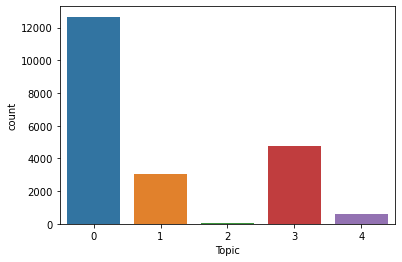

In [32]:
sns.countplot(df_clean['Topic'])

df_clean['Topic'].value_counts()

In [33]:
df_clean.head()

,complaints,lemmatized_text,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is and I appreciate...,3
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my card in / /2018 and wa to...,0
10,chase card was reported on xxxx however fraudu...,Chase Card wa reported on XX/XX/2019 However f...,Chase Card wa reported on / /2019 However fra...,4
11,on xxxx while trying to book a xxxx xxxx tic...,On XX/XX/2018 while trying to book a XXXX XXXX...,On / /2018 while trying to book a ticke...,0
14,my grand son give me check for i deposit it i...,my grand son give me check for { $ 1600.00 } i...,my grand son give me check for { $ 1600.00 } i...,0


In [34]:
Topic_names = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:'Others',
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"
               }

df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [35]:
df_clean.head(20)

,complaints,lemmatized_text,complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,Good morning my name is XXXX XXXX and I apprec...,Good morning my name is and I appreciate...,Theft/Dispute Reporting
2,i upgraded my xxxx xxxx card in xxxx and was t...,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgraded my card in / /2018 and wa to...,Bank Account services
10,chase card was reported on xxxx however fraudu...,Chase Card wa reported on XX/XX/2019 However f...,Chase Card wa reported on / /2019 However fra...,Mortgage/Loan
11,on xxxx while trying to book a xxxx xxxx tic...,On XX/XX/2018 while trying to book a XXXX XXXX...,On / /2018 while trying to book a ticke...,Bank Account services
14,my grand son give me check for i deposit it i...,my grand son give me check for { $ 1600.00 } i...,my grand son give me check for { $ 1600.00 } i...,Bank Account services
15,can you please remove inquiry,Can you please remove inquiry,Can you please remove inquiry,Mortgage/Loan
17,with out notice jp morgan chase restricted my ...,With out notice J.P. Morgan Chase restricted m...,With out notice J.P. Morgan Chase restricted m...,Bank Account services
20,during the summer months i experience a declin...,During the summer month I experience a decline...,During the summer month I experience a decline...,Theft/Dispute Reporting
21,on xxxx xxxx i made a payment to an online re...,On XXXX XX/XX/2019 I made a { $ 300.00 } payme...,On / /2019 I made a { $ 300.00 } payment t...,Bank Account services
23,i have a chase credit card which is incorrectl...,I have a Chase credit card which is incorrectl...,I have a Chase credit card which is incorrectl...,Mortgage/Loan


In [36]:
Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4
               }
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [37]:
training_data = df_clean[["complaint_clean","Topic"]]

In [38]:
training_data

,complaint_clean,Topic
1,Good morning my name is and I appreciate...,3
2,I upgraded my card in / /2018 and wa to...,0
10,Chase Card wa reported on / /2019 However fra...,4
11,On / /2018 while trying to book a ticke...,0
14,my grand son give me check for { $ 1600.00 } i...,0
...,...,...
78303,After being a Chase Card customer for well ove...,0
78309,On Wednesday / / I called Chas my Vis...,0
78310,I am not familiar with pay and did not unde...,0
78311,I have had flawless credit for 30 yr I 've had...,1


In [39]:
# The Vector count

count = CountVectorizer()
X_train_counts = count.fit_transform(training_data.complaint_clean)

# Transform the word vector to tf-idf

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [40]:
# Performing Train-Test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)

In [41]:
X_train.shape

(16857, 27539)

In [42]:
X_test.shape

(4215, 27539)

In [43]:
# Running the Logistic Regression model

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [44]:
print(accuracy_score(y_test,y_pred))

0.9148279952550415


In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2558
           1       0.85      0.78      0.81       604
           2       1.00      0.57      0.73         7
           3       0.92      0.89      0.90       931
           4       0.83      0.74      0.78       115

    accuracy                           0.91      4215
   macro avg       0.91      0.79      0.83      4215
weighted avg       0.91      0.91      0.91      4215



In [46]:
print(confusion_matrix(y_test,y_pred))

[[2471   44    0   41    2]
 [  97  472    0   26    9]
 [   1    1    4    1    0]
 [  77   24    0  824    6]
 [  10   15    0    5   85]]


In [60]:
# Running the Decision Tree

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(criterion ='entropy',random_state=42)
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

In [61]:
print(accuracy_score(y_test,y_pred))

0.7497034400948992


In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2558
           1       0.51      0.52      0.51       604
           2       0.62      0.71      0.67         7
           3       0.68      0.66      0.67       931
           4       0.53      0.53      0.53       115

    accuracy                           0.75      4215
   macro avg       0.64      0.65      0.64      4215
weighted avg       0.75      0.75      0.75      4215



In [50]:
print(confusion_matrix(y_test,y_pred))

[[2158  180    2  196   22]
 [ 193  312    0   77   22]
 [   0    0    5    1    1]
 [ 211   95    1  615    9]
 [  20   25    0    9   61]]


In [51]:
# Random forest 

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=50,random_state=42)
classifier.fit(X_train,y_train)

y_pred = classifier.predict(X_test)

In [52]:
print(accuracy_score(y_test,y_pred))

0.8227758007117437


In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      2558
           1       0.87      0.41      0.56       604
           2       1.00      0.71      0.83         7
           3       0.94      0.66      0.77       931
           4       0.86      0.61      0.71       115

    accuracy                           0.82      4215
   macro avg       0.89      0.68      0.75      4215
weighted avg       0.84      0.82      0.81      4215



In [54]:
print(confusion_matrix(y_test,y_pred))

[[2533   10    0   11    4]
 [ 323  250    0   25    6]
 [   1    1    5    0    0]
 [ 302   18    0  610    1]
 [  36    7    0    2   70]]


In [55]:
# Function to predict a topic for given text

def predict_topic(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    new_counts = count.transform(text)
    X_new_tfidf = tfidf_transformer.transform(new_counts)
    predicted = lr.predict(X_new_tfidf)

    return target_names[predicted[0]]

In [58]:
# Create a dataframe of some sample customer complaints
df_new = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "I need to know the number of bank branches and their locations in the city of Delhi"]})
df_new

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,I need to know the number of bank branches and...


In [59]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model

df_new['predicted topic'] = df_new['complaints'].apply(lambda x: predict_topic([x]))
df_new

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Theft/Dispute Reporting
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,I need to know the number of bank branches and...,Bank Account services
